In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap           # note that umap is not umap in pip, it's umap-learn
import plotly.express as px
from sklearn.manifold import TSNE
import time

In [84]:
#Loading all the data files
data3 = pd.read_csv('../data/kmers/kmer_3.csv')
data5 = pd.read_csv('../data/kmers/kmer_5.csv')
data7 = pd.read_csv('../data/kmers/kmer_7.csv')

data3.head(10)

,Unnamed: 0,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,...,country_exposure,division_exposure,length,age,sex,pangolin_lineage,year,month,day,variant
0,hCoV-19/Philippines/PH-PGC-03838/2021,920,613.0,580.0,757,806.0,372,165.0,671.0,600.0,...,Philippines,National Capital Region,29854,47,Male,B.1.1.7,2021,1,22,Alpha
1,hCoV-19/Philippines/PH-PGC-106429/2022,916,609.0,573.0,761,798.0,368,164.0,665.0,599.0,...,Philippines,Bicol,29829,22,Male,BA.2.3,2022,1,6,Omicron
2,hCoV-19/Philippines/PH-VUI-124638/2022,923,613.0,578.0,767,803.0,369,161.0,671.0,601.0,...,Philippines,Davao,29821,24,Female,BA.5.2,2022,8,9,Omicron
3,hCoV-19/Philippines/PH-PGC-55519/2021,905,599.0,568.0,753,795.0,363,160.0,661.0,590.0,...,Philippines,Mimaropa,29848,31,Male,B.1.351,2021,6,9,Beta
4,hCoV-19/Philippines/PGCV_0034_3370/2022,925,610.0,580.0,765,803.0,370,162.0,668.0,606.0,...,Philippines,Western Visayas,29849,27,Female,BA.2.3.20,2022,9,11,Omicron
5,hCoV-19/Philippines/PH-PGC-104986/2022,922,613.0,577.0,763,802.0,371,164.0,670.0,602.0,...,Philippines,Ilocos,29840,72,Male,BA.2.3,2022,1,10,Omicron
6,hCoV-19/Philippines/PH-PGC-111056/2022,923,613.0,579.0,762,802.0,371,164.0,670.0,602.0,...,Philippines,Davao,29846,25,Male,BA.2.3,2022,2,2,Omicron
7,hCoV-19/Philippines/PH-PGC-64037/2021,924,614.0,576.0,765,805.0,371,162.0,675.0,599.0,...,Philippines,Calabarzon,29883,40,Male,AY.122,2021,8,1,Delta
8,hCoV-19/Philippines/PGCV_0047_4997/2022,924,611.0,581.0,763,803.0,371,162.0,668.0,606.0,...,Philippines,Western Visayas,29846,76,Male,CM.8.1,2022,12,8,Omicron
9,hCoV-19/Philippines/PH-PGC-21762/2021,881,606.0,573.0,758,805.0,367,164.0,669.0,596.0,...,Philippines,National Capital Region,29802,45,Female,B.1.351,2021,3,27,Beta


In [85]:
# Scratch
slice_col = data3.columns.get_loc('strain')
X = data3.iloc[:, 1:slice_col]
X
target = data3['variant']
list(map(lambda var: var.replace('_', ' ').title(), target.unique()))
sorted(list(target.unique()))

['Alpha', 'Beta', 'Delta', 'Omicron', 'Omicron Sub']

## Method 1: Principal Component Analysis 

In [92]:
def pca(data,image_name):
    slice_col = data.columns.get_loc('strain')
    X = data.iloc[:, 1:slice_col]
    target = data['variant']
    x = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    PC = pca.fit_transform(x)
    PDF = pd.DataFrame(data = PC,columns = ['Principal Component 1', 'Principal Component 2'])
    FDF = pd.concat([PDF, data['variant']], axis = 1)
    print('Variance of each component:', pca.explained_variance_ratio_)
    fig = plt.figure(figsize = (10,10))
    plt.rcParams['font.size'] = 20
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel("Principal Component 1 ({:.2%})".format(pca.explained_variance_ratio_[0]))
    ax.set_ylabel("Principal Component 2 ({:.2%})".format(pca.explained_variance_ratio_[1]))
    targets = sorted(list(target.unique()))
    colors = ['r','b','g','m','c']
    for target, color in zip(targets,colors):
        rowsToKeep = FDF['variant'] == target    # ensures that variant rows are mapped to correct data
        ax.scatter(FDF.loc[rowsToKeep, 'Principal Component 1']
               , FDF.loc[rowsToKeep, 'Principal Component 2']
               , c = color
               , s = 40
                )
    ax.legend(targets,loc='best')
    plt.savefig(image_name)

Variance of each component: [0.95501869 0.01258744]
Variance of each component: [0.60842177 0.06270218]
Variance of each component: [0.1639139 0.0537407]


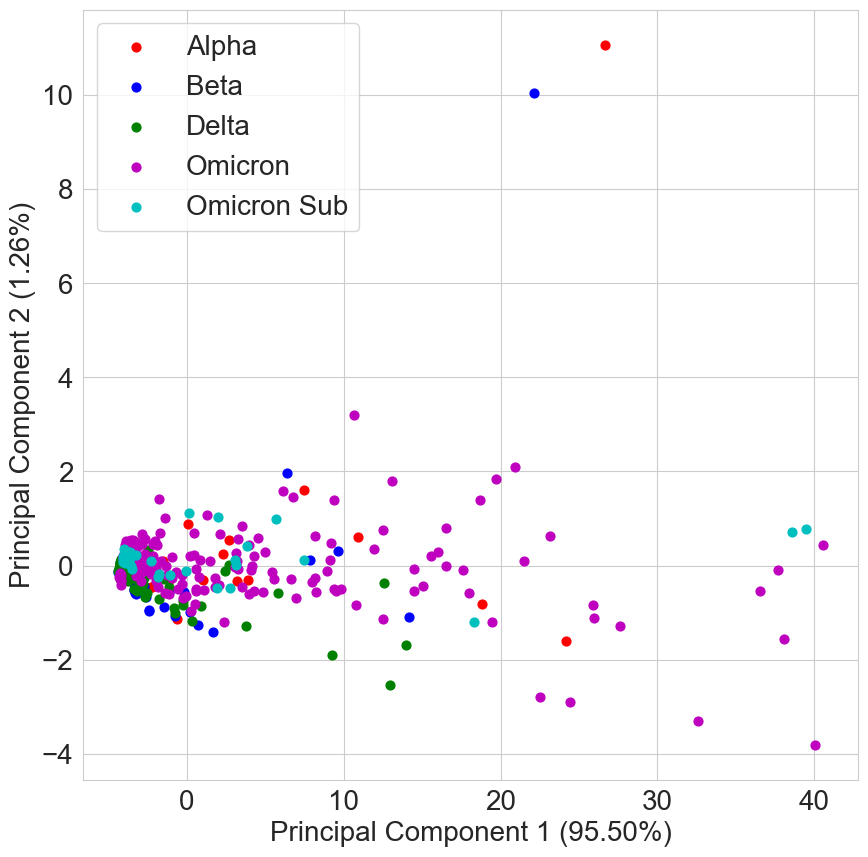

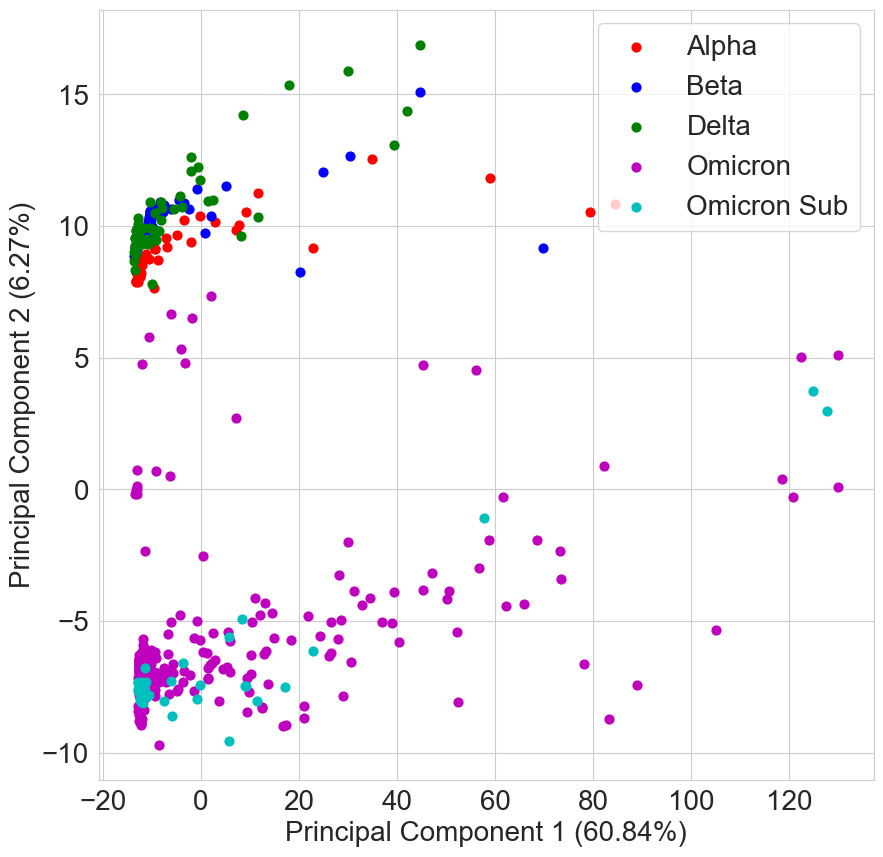

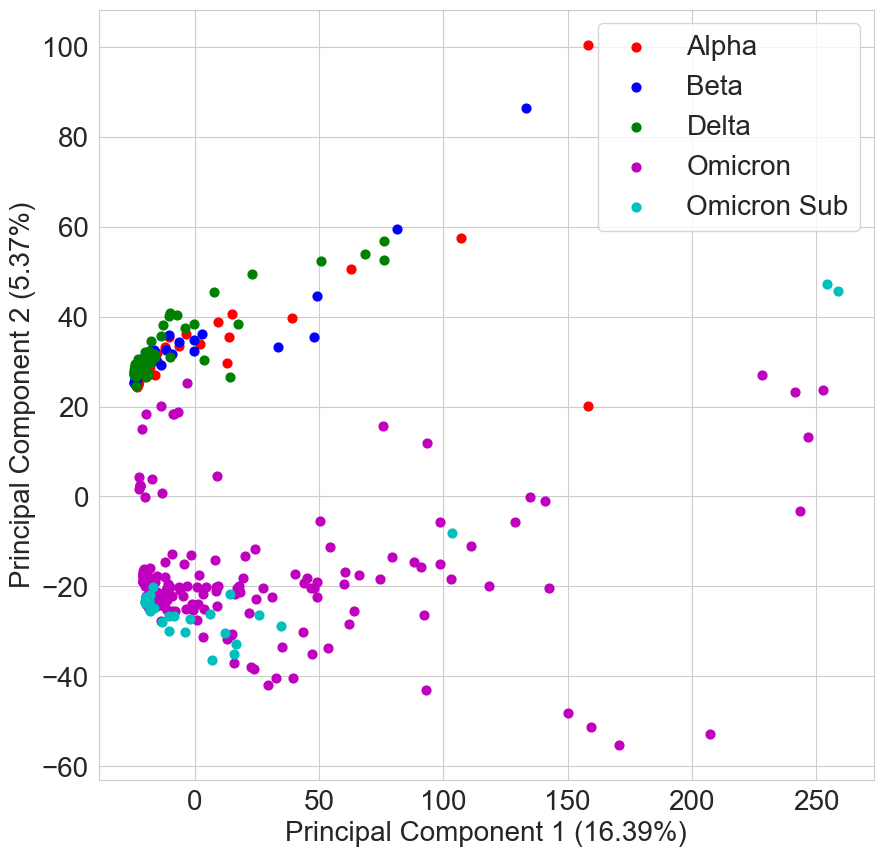

In [93]:
pca(data3,'../results/dim-reduce/pca-kmer-3.png')
pca(data5,'../results/dim-reduce/pca-kmer-5.png')
pca(data7,'../results/dim-reduce/pca-kmer-7.png')

### Combined PCA screenplot

In [102]:
def pcaPlot(data, pt, color, label):
    global fig
    slice_col = data.columns.get_loc('strain')
    X = data.iloc[:, 1:slice_col]
    target = data['variant']
    x = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 10)
    PC = pca.fit_transform(x)
    print('Variance of each component:', pca.explained_variance_ratio_)

    plt.rcParams['font.size'] = 20
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, pt, linewidth=2, color=color,label=label)
    
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Proportion of Variance Explained')
    plt.legend(loc='best')
    plt.savefig('../results/dim-reduce/pca-combined.png')

Variance of each component: [0.95501869 0.01258744 0.00666114 0.00364281 0.00319724 0.00227937
 0.00160215 0.00143249 0.00140039 0.00106193]
Variance of each component: [0.60842177 0.06270218 0.02635902 0.02234892 0.01818415 0.01582287
 0.01349114 0.01195068 0.010913   0.01049341]
Variance of each component: [0.1639139  0.0537407  0.0448182  0.03609264 0.02753906 0.02519982
 0.02095668 0.0190368  0.01853194 0.01660445]


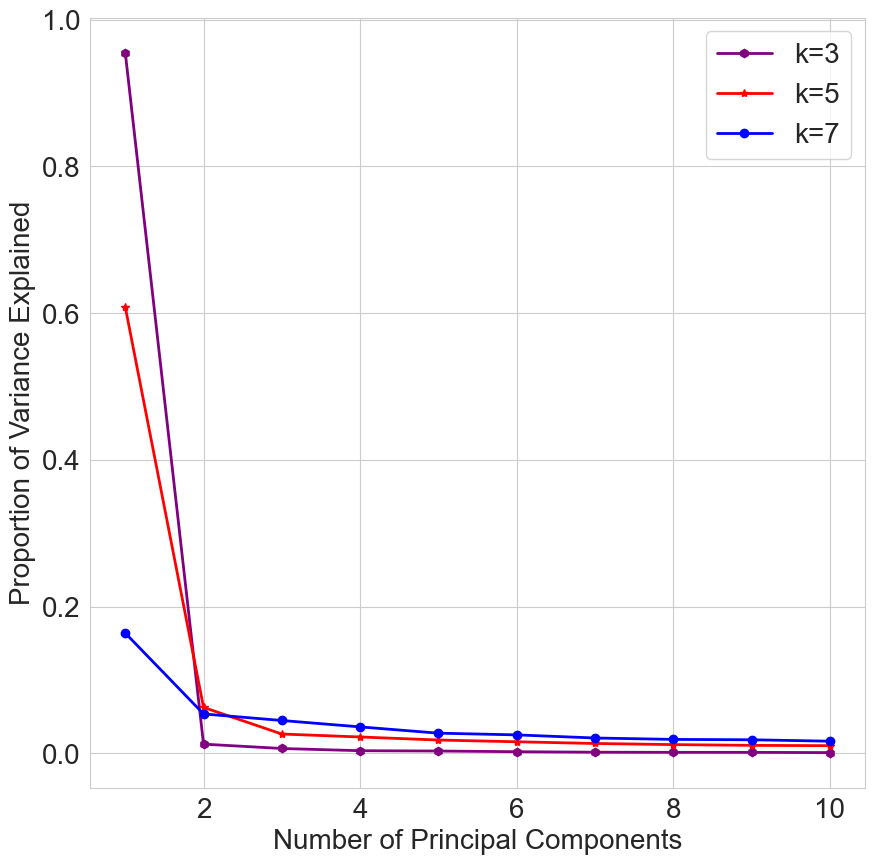

In [104]:
fig = plt.figure(figsize = (10,10))
pcaPlot(data3, 'h-', 'purple', 'k=3')
pcaPlot(data5, '*-', 'red', 'k=5')
pcaPlot(data7, 'o-', 'blue', 'k=7')

## Method 2: t-Distributed Stochastic Neighbor Embedding

In [ ]:
def tsne_fn(data):
    slice_col = data.columns.get_loc('strain')
    X = data.iloc[:, 1:slice_col]
    target = data['variant']
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results_1 = tsne.fit_transform(X)
    fig = px.scatter(
    tsne_results_1, x=0, y=1,
    color=data.target, labels={'color': 'Strain'})
    fig.update_layout(
        xaxis_title="TSNE-2D-1",
        yaxis_title="TSNE-2D-2",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"))
    fig.update_xaxes(showgrid=False,zeroline=False)
    fig.update_yaxes(showgrid=False,zeroline=False)
    fig.show()

In [ ]:
tsne_fn(data3)
tsne_fn(data5)
tsne_fn(data7)

## Method 3: Uniform Manifold Approximation and Projection (UMAP)

In [ ]:
def umap_fn(data):
    X = data.drop(['target'], axis = 1)
    target = data['target']
    umap_reduce = umap.UMAP()
    scaled_X = StandardScaler().fit_transform(X)
    emb = umap_reduce.fit_transform(scaled_X)
    emb.shape
    X_o = emb[:,0]
    Y_o = emb[:,1]
    umap_2d = px.scatter(
        emb, x= 0, y= 1,
        color=data.target, labels={'color': 'Strain'})
    umap_2d.update_layout(
    xaxis_title="UMAP_1",
    yaxis_title="UMAP_2",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"))
    umap_2d.update_xaxes(showgrid=False,zeroline=False)
    umap_2d.update_yaxes(showgrid=False,zeroline=False)
    umap_2d.show()

In [ ]:
umap_fn(data3)
umap_fn(data5)
umap_fn(data7)